# Rapport de projet de session - IFT 712
### Objectif du projet : tester six méthodes de classification sur une base de données Kaggle.

Nous avons choisi la base de données "[Heart Failure Prediction Dataset][0]" puisqu'elle permet de faire de la classification sur un jeu de données réel et avec des applications concrètes.
Les méthodes de classification que nous allons tester sont les suivantes :
* Modèle génératif
* K plus proches voisins
* Régression logistique
* Méthode à noyaux
* SVM
* Perceptron multicouches

Pour cela, nous utiliserons la bibliothèque scikit-learn pour implémenter les algotihmes ainsi que pandas  pour traiter les données

Nous utiliserons également [Trello][1] ainsi que discord afin d'organiser le projet
Le code est versionné sur [Github][1] en suivant les conventions suivantes :
* conventionals [commits][3]
* merge requests sur master
* une branche par feature (i.e par algorithme de classification)

Le code et les commentaires sont rédigés en francais et suivant la convention [pep8][4]. Nous utiliserons la fonctionnalité "code with me" de pycharm permettant à plussieurs membres du groupe de coder sur le même projet en même temps

[0]: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
[1]: https://trello.com/b/U21MHLaj/projet-ift712-deadline-11-12-23
[2]: https://github.com/MorganChabaudENSSAT/projet_ift712
[3]: https://www.conventionalcommits.org/en/v1.0.0/
[4]: https://peps.python.org/pep-0008/

In [1]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import warnings

'''
 Imporation des bibliothèques spécifiques au devoir
'''
from regression_logistique import RegressionLogistique
import utils

'''
    Suppression des Future Warnings 
'''
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Importation des données
df = pd.read_csv('heart.csv') # Dataframe contenant les données
features_names = df.columns
features_nbr = features_names.shape[0]
print(f"nombre de features dans le dataset : {features_nbr}")
# Visualisation des données pour mieux les comprendre
print(df.head())
print(df.dtypes)

nombre de features dans le dataset : 12
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG 

A partir de cette visualisation primaire des données, on  remarque que certaines features sont catégoriques ce qui empêche de les utiliser telles quelles dans les algorithmes de classification.
=> On va donc devoir traiter ces valeurs en les encodant.

In [3]:
le = LabelEncoder()

data = df.copy(deep = True)

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

# Les données sont mainteant toutes numériques et utilisables par les algorithmes de classification que nous mettrons en place
print(data)

#On récupère dasn des listes les données qui était catégoriques
categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
numerical_features = [x for x in features_names if x not in categorical_features]
numerical_features = numerical_features[:-1]

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

A présent, on explore les données à l'aide de visualisations afin de mieux comprendre leur nature et détecter les features les plus caractéristiques ainsi que la nature des distributions des données afin, au besoin, de formuler des hypothèses nous permettant de mettre en oeuvre différents modèles.
On commence par visualiser la distribution de chaque feature.

C:\Users\taill\AppData\Local\Temp\ipykernel_19984\1165184245.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
C:\Users\taill\anaconda3\lib\site-packages\seaborn\distributions.py:2496: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\taill\AppData\Local\Temp\ipykernel_19984\1165184245.py:6: UserWarning: 

`distplot` is a deprecated function and will be remove

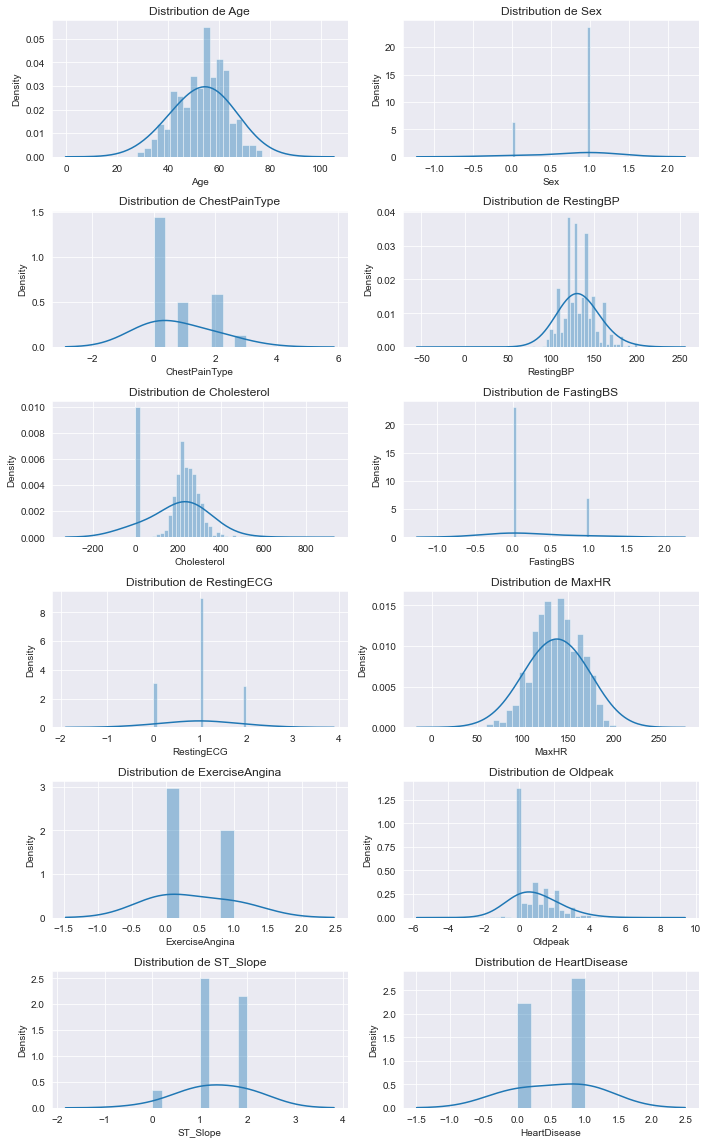

In [4]:
fig = plt.figure(figsize=(10,16))
for i in range(features_nbr):
    plt.subplot(int(features_nbr/2), 2, i+1)
    fig.tight_layout()
    cur_feature =features_names[i]
    sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
    plt.title("Distribution de "+cur_feature)

Les données semblent suivre approximativement une distribution normale dans une majorité de cas. On assumera donc dans la suite du projet, lorsque cela est nécessaire que les données suivent une loi normale.

# 1 - Régression logistique #

In [5]:
# Création d'un modèle de base
reg_log=RegressionLogistique(data, features_names, features_nbr)

On met à l'echelle les données afin de réduire l'impact des différentes valeurs que peuvent prendre les données sur la précision du modèle.
La visualisation des données a mis en évidence les phénomènes suivants:
- blablabla
- ascqs
- qfds

On normalise les donées correspondant aux features ..... de sorte à les ramener entre 0 et 1
On standardise les données suivant déjà une distribution gaussienne  pour empêcher le svelurs extrèmes de fausser les résultats.

In [6]:
# Mise à echelle des données
scaled_data = reg_log.scale_data()
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = reg_log.split_data(scaled_data)

          Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140    1              1   0.410909     0.825070  -0.551341   
1   -0.478484    0              2   1.491752    -0.171961  -0.551341   
2   -1.751359    1              1  -0.129513     0.770188  -0.551341   
3   -0.584556    0              0   0.302825     0.139040  -0.551341   
4    0.051881    1              2   0.951331    -0.034755  -0.551341   
..        ...  ...            ...        ...          ...        ...   
913 -0.902775    1              3  -1.210356     0.596393  -0.551341   
914  1.536902    1              0   0.627078    -0.053049   1.813758   
915  0.370100    1              0  -0.129513    -0.620168  -0.551341   
916  0.370100    0              1  -0.129513     0.340275  -0.551341   
917 -1.645286    1              2   0.302825    -0.217696  -0.551341   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0             1  1.382928               0 -0.832432      

In [7]:
# Entraînement du modèle sur les données d'entraînement
reg_log.train(X_train, y_train)

In [8]:
# Evaluation du modèle sur les données de test
reg_log.evaluate_model(X_train,y_train)
reg_log.evaluate_model(X_test,y_test)


Le score de validation croisée est :  0.8474326716988166 avec un déviation standard de :  0.013793757277781649
[[272  55]
 [ 49 358]]
accuracy du modèle : 0.8583106267029973
Le score de validation croisée est :  0.8205705705705706 avec un déviation standard de :  0.08142790908682435
[[69 14]
 [13 88]]
accuracy du modèle : 0.8532608695652174


### Recherche d'un modèle de plus grande capacité ###
On cheche a présent à obtenir un modèle de plus grande qualité. Pour cela, on va comparer plusieurs régressions logistiques initialisées avec des hyperparamètres dfférents afin d'obtenir la combinaison optimal des hyperparamètres.
D'après le site de la bibliothèque sklearn, les hyperparamètres sur lesquels il est le plus important d'influer dans le cadre de la régression logistique et que nous étudierons en conséquence sont les suivants:
- le 'solver' c'est à dire l'algorithme d'optimisation qui minimise la loss
- 'penalty' qui correspond à la norme employée dans le terme de régularisation
- 'C' est la constante qui régule l'impact du terme de régularisation (c'est l'inverse de la force de régularisation)

Par la suite, on cherche donc a analyser les résultats des différentes combinaisons d'hyperparamètres de sorte à maximiser la capacité du système **tout en** l'empêchant d'overfitter sur les données. Pour cela, on visualiseras l'évolution de l'accuracy sur les ensembles d'entraînement et de validation en procédant à une recherche d'hyperparamètres de type 'grid-search' reposant sur la 'cross_validation'


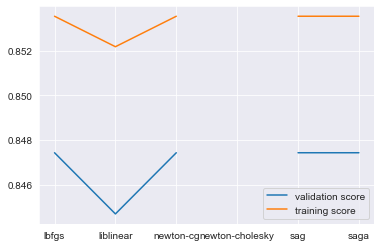

In [9]:
from sklearn.model_selection import validation_curve

h_parameters_to_tune ={
    'solver' : ['lbfgs', 'liblinear','newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty' : ['None','l2', 'l1', 'elasticnet'],
    'C' : [1.0, 10.0, 100.0, 1000.0, 10000.0]
}
model = LogisticRegression(random_state=16)
k = np.linspace(1,20,20)
train_score, val_score = validation_curve(model, X_train, y_train, param_name='solver', param_range=['lbfgs', 'liblinear','newton-cg', 'newton-cholesky', 'sag', 'saga'], cv=5)

plt.plot(['lbfgs', 'liblinear','newton-cg', 'newton-cholesky', 'sag', 'saga'], val_score.mean(axis=1),label='validation score')
plt.plot(['lbfgs', 'liblinear','newton-cg', 'newton-cholesky', 'sag', 'saga'], train_score.mean(axis=1),label='training score')
plt.legend()

In [10]:
best_estimator = reg_log.recherche_hyper_parametres(X_train, y_train, h_parameters_to_tune)

0.8569482288828338
0.8487932159165036  pour les hyperparamètres suivants :  {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\taill\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
425 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\taill\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\taill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\taill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 441, in _check_solver
    raise ValueError(
V

In [11]:
best_reg_log = RegressionLogistique(data, features_names, features_nbr, best_estimator)
print(best_reg_log.logreg)
best_reg_log.train(X_train,y_train)
best_reg_log.evaluate_model(X_test, y_test)

LogisticRegression(penalty='l1', solver='liblinear')
Le score de validation croisée est :  0.8205705705705706 avec un déviation standard de :  0.08142790908682435
[[69 14]
 [14 87]]
accuracy du modèle : 0.8478260869565217


# 2 - K plus proches voisins

Dans cette partie, on classifie les données à l'aide du classifieur par K plus proches voisins.
Nous évaluerons la valeur de l'hyperparamètre K à l'aide d'une recherche de type 'grid-search' utilisant une 'stratified-cross-validation'

On commence par initialiser un classifieur dit 'naïf' avec l'hyperparamètre K=5 afin d'avoir une base sur laquelle travailler.

accuracy du modèle : 0.8206521739130435


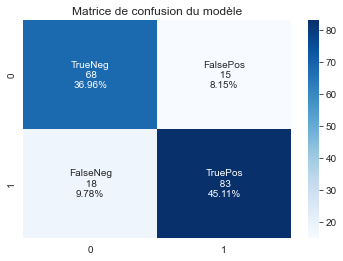

In [12]:
from k_plus_proches_voisins import K_PP_voisins

# Instantiation du modèle avec K =5
knn_model_naif =  K_PP_voisins(data, features_names, features_nbr)
# Entraînement du modèle sur les données X_train et y_train
knn_model_naif.train(X_train, y_train)
# Evaluation du modèle sur les données de test
knn_model_naif.evaluate_model(X_test, y_test)

Le modèle arrive à prédire correctement l'existence ou l'absence de maladie cardiaque dans environ 80% des cas sur les données de tests.

On quantifie la capacité du modèle plus précisemment à l'aide de 'stratified-cross-validation'. Les données sur lesquelles est entrainé le modèle sont séparées en un ensemble d'entraînement et de validation permettant d'évaluer la capacité à généraliser du modèle. On évalue le score de chaque fold puis on en prend la moyenne afin d'obtenir la meilleure évaluation de l'accuracy possible

In [13]:
knn_model_naif.K_fold(X_train,y_train)

Le score de cross-validation du modèle est:  0.8469394051585831


On constate finalement que 

#### Amélioration du modèle : recherche des hyperparamètres

L'analyse de base du classifieur étant établie, on procède maintenant à une recherche d'hyperparamètres. D'après la documentation de [sklearn][1] les hyperparamètres du modèles sont les suivants :
- n_neighbors : le nombre de voisins nécesasires pour la classification du point courant
- weights : La métrique utilisée pour prédire l'appartenance d'un point à une classe ou à une autre
- algorithm : algorithme utilisé pour le calcul
- leaf_size : nombre de points à partir duquel l'algorithme choisi les voisins en force brute
- p : puissance dans la distance de Minkowski indiquant la nature de la mesure
- metric : la métrique utilisée

On conserve la métrique de base (Minkowski) car le choix de la valeur de p permet de choisir la métrique indirectement.
Le jeu de données étant inférieur à 1000 points, on peut utiliser l'approche par force brute directement car le temps de calcul devrait rester raisonnable. Ainsi, on fixe leaf_size à 1.
L'algorithme utilisé pour le calcul des plus proches voisins est laissé à 'auto'.
On fixe p à 1 pour avoir la distance de mahalanobis qui conserve prends en compte la forme des données

Il nous reste donc à calculer les valeurs d'hyperparmètres suivants:
- n_neighbors
- weights
- p

On utilise une recherche d'hyperparamètres de type grid-search. Pour cela, on instancie un dictionnaire contenant les couples (noms du paramètres : valeurs prises par ce paramètre)

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [14]:
n_neighbors_values = np.linspace(1,20,20).astype(int)
weights_values = ['uniform', 'distance']
p_values = np.linspace(1,10,10).astype(int)
h_parameters_to_tune ={
    'n_neighbors' : n_neighbors_values,
    'weights' : weights_values,
    'p' : p_values
}
other_parameters=['leaf-size=1','metric=minkowski']

In [15]:
knn_post_grid_search_estimator = knn_model_naif.hyper_parameters_search(X_train, y_train, h_parameters_to_tune, other_parameters)

0.8706178361755661  pour les hyperparamètres suivants :  {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


On constate une amélioration de l'accuracy du modèle d'environ 4%

In [16]:
knn_2=K_PP_voisins(data, features_names, features_nbr,knn_post_grid_search_estimator)

accuracy du modèle : 0.8641304347826086


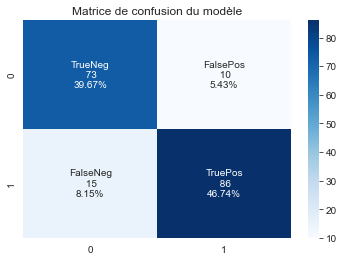

In [17]:
knn_2.evaluate_model(X_test, y_test)

Le modèle s'est amélioré d'environ 2% grâce à un meilleur choix des hyperparamètres

#### Amélioration du modèle : nombre de données

A présent, on étudie le nombre de données nécessaire dans l'ensemble d'entraînement permettant de favoriser l'apprentissage du modèle. Pour cela, on va évaluer la performance du modèle sur plusieurs ensembles d'entraînement dont les tailles sont différentes et afficher les résultats obtenus sous la forme de graphiques.
Afin de valider la capacité à généraliser du modèle, nous visualiserons également le score obtenu sur l'ensemble des données de validation.

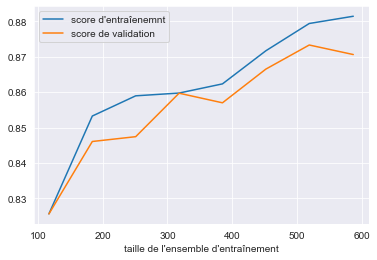

In [18]:
train_size = np.linspace(0.2,1,8)
knn_2.data_needed_for_max_score(X_train, y_train, train_size)

L'allure de la courbe orange représentant le score de validation laisse entendre que davantage de données permettrait d'améliorer les prédictions du modèle.
On constate cependant que le modèle amélioré suite à la recherche des hyperparamètres sur-apprend les données d'entraînement.
il s'agit en effet, d'un des risques des modèles basés sur les K plus proches voisins.

accuracy du modèle : 0.8801089918256131


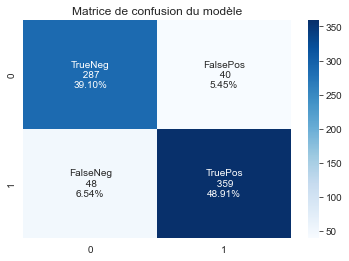

In [19]:
knn_2.evaluate_model(X_train, y_train)

L'évaluation du modèle (sur les données d'entraînement) ci-contre montre bien que le modèle sur-apprend.
Afin de prévenir cela,  nous étudierons et appliquerons diverses transformations aux données.

#### Amélioration du modèle : Mise à l'échelle des données

On normalise les données quantitatives afin de faciliter l'apprentissage du modèle.

In [34]:
scaled_data_knn = knn_2.scale_data(numerical_features,[])

On créer maintenant un nouveau modèle à l'aide de ces données et on l'entraîne.

accuracy du modèle : 0.8641304347826086


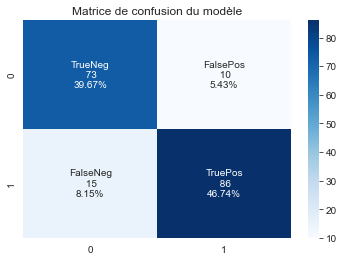

In [35]:
knn_3 = K_PP_voisins(scaled_data_knn,features_names,features_nbr,knn_post_grid_search_estimator)
knn_3.train(X_train,y_train)
knn_3.evaluate_model(X_test,y_test)

In [21]:
print(data)
print(scaled_data)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

In [22]:
knn_2.K_fold(X_train,y_train)
knn_model_naif.K_fold(X_train,y_train)

Le score de cross-validation du modèle est:  0.8719301493274095
Le score de cross-validation du modèle est:  0.8469394051585831


accuracy du modèle : 0.8801089918256131
accuracy du modèle : 0.888283378746594


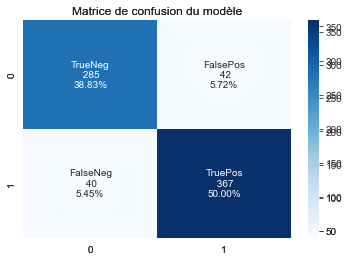

In [23]:
knn_2.evaluate_model(X_train,y_train)
knn_model_naif.evaluate_model(X_train,y_train)

#### Conclusion sur le modèle des K plus proches voisins

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(knn_post_grid_search_estimator,max_samples=0.5, max_features=0.5)

In [25]:
bagging.get_params()

{'base_estimator__algorithm': 'auto',
 'base_estimator__leaf_size': 1,
 'base_estimator__metric': 'minkowski',
 'base_estimator__metric_params': None,
 'base_estimator__n_jobs': None,
 'base_estimator__n_neighbors': 17,
 'base_estimator__p': 1,
 'base_estimator__weights': 'uniform',
 'base_estimator': KNeighborsClassifier(leaf_size=1, n_neighbors=17, p=1),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 0.5,
 'max_samples': 0.5,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [26]:
bagging.fit(X_train,y_train)
bagging.score(X_test, y_test)

0.8206521739130435

accuracy du modèle : 0.8641304347826086


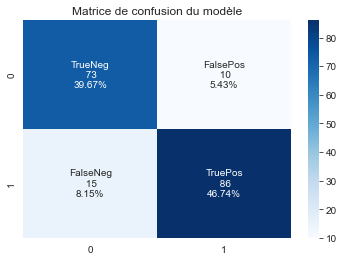

In [29]:
knn_2 = K_PP_voisins(scaled_data, features_names, features_nbr, knn_post_grid_search_estimator)
knn_2.evaluate_model(X_test, y_test)


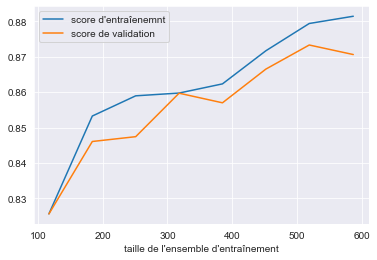

In [30]:
train_size = np.linspace(0.2, 1, 8)
knn_2.data_needed_for_max_score(X_train, y_train, train_size)

In [27]:
knn_post_grid_search_estimator.get_params()

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 17,
 'p': 1,
 'weights': 'uniform'}

Références: 
0 : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea